In [1]:
include("CRNevo.jl")
include("CRNExplore.jl")
include("SymbolicOps.jl")

# --- GA parameters
genetic_pool_size = 1000

death_rate = (rank) -> 0.0*(rank)
mutation_rate = (rank) -> 0.50
gradient_mutation_rate = (rank) -> 0.02*(1-rank)
duplication_rate = (rank) -> 0.48*(1-rank)
crossover_rate = (rank) -> 0.0*(1-rank)
max_generations = 1000
p_cross = 0.1

# --- GD parameters

# fixed, basic steps

N = 3
np = count_parameters(N)
target = N
crn = create_reactions(N)
ode_crn = convert(ODESystem, crn)
pars_l = assemble_opt_parameters_and_varables([0 for _ in 1:np], N) # just for the names
ext_ode = make_sensitivity_ode(ode_crn, pars_l.p)
t0 = 10.0
t1 = 20.0

# set up gd problem 

crn_info = (
    crn = crn, 
    ode_crn = ode_crn,
    ext_ode = ext_ode,
    np = np,
    N = N,
    target = target
)

# set up the loss function

gd_loss_options = (
    weights = [100., 10., 1.0/80, 5], #[2.0, 1.0/3, 1.0/80, 100.0], #[1., 0.01, 0.01, 1.] # this descends smoothly
    p=0.001,
    d=0.5,
    f_ss=0.5,
    norm_for_sensitivity_loss = 1, 
    norm_for_ss_loss = 1,
    norm_for_adaptation_loss = 1,
    n_losses = 4
)

loss_blueprint = prepare_args(nothing, target, t0, t1, pars_l, gd_loss_options.weights, gd_loss_options.p, gd_loss_options.d, gd_loss_options.f_ss, gd_loss_options.norm_for_sensitivity_loss, gd_loss_options.norm_for_ss_loss, gd_loss_options.norm_for_adaptation_loss)

gd_options = (
    alpha = 0.1,
    n_iter = 10,
    use_pruning_heuristic = false,
    clip_value = nothing,
    use_gradient_normalization = false,
    use_adagrad = true, # overrides use_adam!
    use_adam = false,
    use_random_perturbation = false,
    verbose = false,
    # placed here for convenience, should be in gd_loss_options
    symbolic_derivatives_of_loss = compute_symbolic_derivatives_of_loss(total_loss_symbolic(loss_blueprint))
)

gd_perturbation_options = (
    t0 = t0,
    t1 = t1,
    input = 1.,
    perturbation = 1.,
    K = 5,
    perturbation_list = [-1., -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1., 2., 3., 4., 5., 6., 7., 8., 9., 10.],
    loss_blueprint = loss_blueprint
)


mutate_with_GD = (p) -> symbolic_gradient_descent(p, crn_info, gd_options, gd_perturbation_options, gd_loss_options).parameters
function make_ev_loss(crn_info, gd_options, gd_perturbation_options, gd_loss_options)
    function ev_loss(p)
        pars_l = assemble_opt_parameters_and_varables(p, crn_info.N)
        solutions = run_with_fixed_perturbations(crn_info.crn, p, pars_l, gd_perturbation_options.input,  gd_perturbation_options.perturbation_list, gd_perturbation_options.t0, gd_perturbation_options.t1)
        losses = zeros(length(solutions))
        Threads.@threads for i in 1:length(solutions)
            loss_args = update_args(solutions[i], crn_info.target, gd_perturbation_options.t0, gd_perturbation_options.t1, pars_l, gd_perturbation_options.loss_blueprint, gd_loss_options.p, gd_loss_options.d, gd_loss_options.f_ss) 
            losses[i] = total_loss_eval(loss_args).total.val
        end
        return sum(losses)/length(gd_perturbation_options.perturbation_list)
    end
    return ev_loss
end
loss_function = make_ev_loss(crn_info, gd_options, gd_perturbation_options, gd_loss_options)
print("setup done!")

setup done!

In [2]:
reactions(crn)[30] # so we want to edit only parameter 29

k_29, x_3 --> ∅

In [3]:
output_degradation_parameter = 29
minimal_degradation_rate = 0.1

0.1

In [4]:
# println("Testing symbolic gradient descent")
# println(loss_function([1 for _ in 1:np]))
# test_p = symbolic_gradient_descent([1 for _ in 1:np], crn_info, gd_options, gd_perturbation_options, gd_loss_options)
# println(loss_function(test_p.parameters))

initialize the GA problem 

In [5]:
parameter_pool = [[rand() for _ in 1:np] for _ in 1:genetic_pool_size]
is_updated = [false for _ in 1:genetic_pool_size]
fitness = [0. for _ in 1:genetic_pool_size]

dp = 0.05

state = (pool = parameter_pool, is_updated = is_updated, fitness = fitness, history = (best_loss = [], mean_loss = []))
print("done")

done

In [6]:
using ProgressBars
max_generations = 1000
for i in ProgressBar(1:max_generations)
    state = symbolic_evolve_NFB(crn, loss_function, state, dp, genetic_pool_size, death_rate, mutation_rate, gradient_mutation_rate, mutate_with_GD, duplication_rate, crossover_rate, p_cross, output_degradation_parameter, minimal_degradation_rate)
end

0.0%┣                                           ┫ 0/1.0k [00:03<-49:-31, -3s/it]


0.1%┣                                         ┫ 1/1.0k [01:33<Inf:Inf, InfGs/it]


0.2%┣                                         ┫ 2/1.0k [02:50<47:09:15, 170s/it]


0.3%┣▏                                        ┫ 3/1.0k [03:54<32:26:37, 117s/it]


0.4%┣▏                                         ┫ 4/1.0k [04:47<26:29:20, 96s/it]


0.5%┣▏                                         ┫ 5/1.0k [06:10<25:35:10, 93s/it]


0.6%┣▎                                         ┫ 6/1.0k [07:28<24:43:26, 90s/it]


0.7%┣▎                                         ┫ 7/1.0k [08:19<22:57:27, 83s/it]


0.8%┣▍                                         ┫ 8/1.0k [09:02<21:20:18, 77s/it]


0.9%┣▍                                         ┫ 9/1.0k [09:42<20:01:46, 73s/it]


1.0%┣▍                                        ┫ 10/1.0k [10:58<20:07:09, 73s/it]


1.1%┣▌                                        ┫ 11/1.0k [11:49<19:28:47, 71s/it]


1.2%┣▌                                        ┫ 12/1.0k [12:34<18:49:02, 69s/it]


1.3%┣▌                                        ┫ 13/1.0k [13:18<18:13:42, 66s/it]


1.4%┣▋                                        ┫ 14/1.0k [14:20<18:06:31, 66s/it]


1.5%┣▋                                        ┫ 15/1.0k [15:15<17:53:01, 65s/it]


1.6%┣▋                                        ┫ 16/1.0k [16:01<17:30:49, 64s/it]


1.7%┣▊                                        ┫ 17/1.0k [16:39<17:02:38, 62s/it]


1.8%┣▊                                        ┫ 18/1.0k [17:14<16:35:50, 61s/it]


1.9%┣▉                                        ┫ 19/1.0k [18:11<16:30:34, 61s/it]


2.0%┣▉                                        ┫ 20/1.0k [19:03<16:22:16, 60s/it]


2.1%┣▉                                        ┫ 21/1.0k [19:58<16:17:22, 60s/it]


2.2%┣█                                        ┫ 22/1.0k [20:55<16:14:04, 60s/it]


2.3%┣█                                        ┫ 23/1.0k [21:45<16:05:57, 59s/it]


2.4%┣█                                        ┫ 24/1.0k [22:34<15:57:41, 59s/it]


2.5%┣█                                        ┫ 25/1.0k [23:23<15:50:01, 58s/it]


2.6%┣█                                        ┫ 26/1.0k [24:45<16:04:24, 59s/it]


2.7%┣█                                        ┫ 27/1.0k [25:52<16:08:18, 60s/it]


2.8%┣█▏                                       ┫ 28/1.0k [26:46<16:03:37, 59s/it]


2.9%┣█▏                                       ┫ 29/1.0k [27:26<15:51:20, 59s/it]


3.0%┣█▎                                       ┫ 30/1.0k [28:21<15:48:24, 59s/it]


3.1%┣█▎                                       ┫ 31/1.0k [29:01<15:37:25, 58s/it]


3.2%┣█▎                                       ┫ 32/1.0k [29:54<15:33:39, 58s/it]


3.3%┣█▍                                       ┫ 33/1.0k [31:05<15:39:07, 58s/it]


3.4%┣█▍                                       ┫ 34/1.0k [31:57<15:35:06, 58s/it]


3.5%┣█▍                                       ┫ 35/1.0k [33:04<15:38:37, 58s/it]


3.6%┣█▌                                       ┫ 36/1.0k [34:00<15:36:15, 58s/it]


3.7%┣█▌                                       ┫ 37/1.0k [35:02<15:37:02, 58s/it]


3.8%┣█▋                                       ┫ 38/1.0k [35:45<15:29:31, 58s/it]


3.9%┣█▋                                       ┫ 39/1.0k [36:44<15:29:04, 58s/it]


4.0%┣█▋                                       ┫ 40/1.0k [37:33<15:24:22, 58s/it]


4.1%┣█▊                                       ┫ 41/1.0k [38:24<15:20:37, 58s/it]


4.2%┣█▊                                       ┫ 42/1.0k [39:15<15:17:02, 57s/it]


4.3%┣█▊                                       ┫ 43/1.0k [40:14<15:16:51, 57s/it]


4.4%┣█▉                                       ┫ 44/1.0k [41:05<15:13:28, 57s/it]


4.5%┣█▉                                       ┫ 45/1.0k [41:56<15:10:14, 57s/it]


4.6%┣█▉                                       ┫ 46/1.0k [42:46<15:06:35, 57s/it]


4.7%┣██                                       ┫ 47/1.0k [43:28<15:00:39, 57s/it]


4.8%┣██                                       ┫ 48/1.0k [44:17<14:56:58, 57s/it]


4.9%┣██                                       ┫ 49/1.0k [45:16<14:56:49, 57s/it]


5.0%┣██                                       ┫ 50/1.0k [46:02<14:52:38, 56s/it]


5.1%┣██                                       ┫ 51/1.0k [47:01<14:52:17, 56s/it]


5.2%┣██▏                                      ┫ 52/1.0k [47:58<14:51:31, 56s/it]


5.3%┣██▏                                      ┫ 53/1.0k [48:55<14:50:45, 56s/it]


5.4%┣██▏                                      ┫ 54/1.0k [49:50<14:49:23, 56s/it]


5.5%┣██▎                                      ┫ 55/1.0k [50:38<14:46:05, 56s/it]


5.6%┣██▎                                      ┫ 56/1.0k [51:28<14:43:15, 56s/it]


5.7%┣██▍                                      ┫ 57/1.0k [52:31<14:44:13, 56s/it]


5.8%┣██▍                                      ┫ 58/1.0k [53:38<14:46:21, 56s/it]


5.9%┣██▍                                      ┫ 59/1.0k [54:34<14:45:15, 56s/it]


6.0%┣██▌                                      ┫ 60/1.0k [56:02<14:52:41, 57s/it]


6.1%┣██▌                                      ┫ 61/1.0k [57:04<14:53:01, 57s/it]


6.2%┣██▌                                      ┫ 62/1.0k [58:02<14:52:15, 57s/it]


6.3%┣██▋                                      ┫ 63/1.0k [59:04<14:52:40, 57s/it]


6.4%┣██▍                                   ┫ 64/1.0k [01:00:12<14:54:22, 57s/it]


6.5%┣██▌                                   ┫ 65/1.0k [01:01:02<14:51:35, 57s/it]


6.6%┣██▌                                   ┫ 66/1.0k [01:01:54<14:49:31, 57s/it]


6.7%┣██▌                                   ┫ 67/1.0k [01:03:06<14:51:56, 57s/it]


6.8%┣██▋                                   ┫ 68/1.0k [01:03:57<14:49:35, 57s/it]


6.9%┣██▋                                   ┫ 69/1.0k [01:04:42<14:45:44, 57s/it]


7.0%┣██▋                                   ┫ 70/1.0k [01:05:26<14:41:55, 57s/it]


7.1%┣██▊                                   ┫ 71/1.0k [01:06:22<14:40:45, 57s/it]


7.2%┣██▊                                   ┫ 72/1.0k [01:07:19<14:39:46, 57s/it]


7.3%┣██▊                                   ┫ 73/1.0k [01:08:09<14:37:25, 57s/it]


7.4%┣██▉                                   ┫ 74/1.0k [01:09:02<14:35:37, 57s/it]


7.5%┣██▉                                   ┫ 75/1.0k [01:09:50<14:33:00, 57s/it]


7.6%┣██▉                                   ┫ 76/1.0k [01:10:25<14:27:35, 56s/it]


7.7%┣███                                   ┫ 77/1.0k [01:11:19<14:26:12, 56s/it]


7.8%┣███                                   ┫ 78/1.0k [01:12:01<14:22:14, 56s/it]


7.9%┣███                                   ┫ 79/1.0k [01:12:41<14:18:18, 56s/it]


8.0%┣███                                   ┫ 80/1.0k [01:13:22<14:14:25, 56s/it]


8.1%┣███                                   ┫ 81/1.0k [01:14:02<14:10:31, 56s/it]


8.2%┣███▏                                  ┫ 82/1.0k [01:14:43<14:06:53, 55s/it]


8.3%┣███▏                                  ┫ 83/1.0k [01:15:38<14:05:50, 55s/it]


8.4%┣███▏                                  ┫ 84/1.0k [01:16:26<14:03:36, 55s/it]


8.5%┣███▎                                  ┫ 85/1.0k [01:17:17<14:01:49, 55s/it]


8.6%┣███▎                                  ┫ 86/1.0k [01:18:01<13:58:50, 55s/it]


8.7%┣███▎                                  ┫ 87/1.0k [01:18:45<13:56:02, 55s/it]


8.8%┣███▍                                  ┫ 88/1.0k [01:19:36<13:54:29, 55s/it]


8.9%┣███▍                                  ┫ 89/1.0k [01:20:30<13:53:19, 55s/it]


9.0%┣███▍                                  ┫ 90/1.0k [01:21:26<13:52:38, 55s/it]


9.1%┣███▌                                  ┫ 91/1.0k [01:22:09<13:49:42, 55s/it]


9.2%┣███▌                                  ┫ 92/1.0k [01:22:58<13:47:47, 55s/it]


9.3%┣███▌                                  ┫ 93/1.0k [01:23:27<13:42:43, 54s/it]


9.4%┣███▋                                  ┫ 94/1.0k [01:24:15<13:40:47, 54s/it]


9.5%┣███▋                                  ┫ 95/1.0k [01:25:06<13:39:19, 54s/it]


9.6%┣███▋                                  ┫ 96/1.0k [01:25:54<13:37:24, 54s/it]


9.7%┣███▊                                  ┫ 97/1.0k [01:26:38<13:34:55, 54s/it]


9.8%┣███▊                                  ┫ 98/1.0k [01:27:25<13:32:55, 54s/it]


9.9%┣███▊                                  ┫ 99/1.0k [01:28:09<13:30:26, 54s/it]


10.0%┣███▋                                ┫ 100/1.0k [01:28:47<13:27:10, 54s/it]


10.1%┣███▋                                ┫ 101/1.0k [01:29:35<13:25:22, 54s/it]


10.2%┣███▊                                ┫ 102/1.0k [01:30:23<13:23:33, 54s/it]


10.3%┣███▊                                ┫ 103/1.0k [01:31:08<13:21:29, 54s/it]


10.4%┣███▊                                ┫ 104/1.0k [01:32:01<13:20:31, 54s/it]


10.5%┣███▉                                ┫ 105/1.0k [01:32:53<13:19:20, 54s/it]


10.6%┣███▉                                ┫ 106/1.0k [01:33:51<13:19:03, 54s/it]


10.7%┣███▉                                ┫ 107/1.0k [01:34:35<13:16:49, 54s/it]


10.8%┣███▉                                ┫ 108/1.0k [01:35:31<13:16:18, 54s/it]


10.9%┣████                                ┫ 109/1.0k [01:36:14<13:13:59, 53s/it]


11.0%┣████                                ┫ 110/1.0k [01:36:50<13:10:38, 53s/it]


11.1%┣████                                ┫ 111/1.0k [01:37:55<13:11:22, 53s/it]


11.2%┣████                                ┫ 112/1.0k [01:38:54<13:11:09, 53s/it]


11.3%┣████                                ┫ 113/1.0k [01:39:35<13:08:41, 53s/it]


11.4%┣████                                ┫ 114/1.0k [01:40:43<13:09:39, 53s/it]


11.5%┣████▏                               ┫ 115/1.0k [01:41:37<13:08:53, 53s/it]


11.6%┣████▏                               ┫ 116/1.0k [01:42:23<13:07:03, 53s/it]


11.7%┣████▏                               ┫ 117/1.0k [01:43:03<13:04:27, 53s/it]


11.8%┣████▎                               ┫ 118/1.0k [01:43:56<13:03:32, 53s/it]


11.9%┣████▎                               ┫ 119/1.0k [01:44:32<13:00:28, 53s/it]


12.0%┣████▎                               ┫ 120/1.0k [01:45:13<12:58:05, 53s/it]


12.1%┣████▍                               ┫ 121/1.0k [01:46:05<12:57:00, 53s/it]


12.2%┣████▍                               ┫ 122/1.0k [01:46:53<12:55:32, 53s/it]


12.3%┣████▍                               ┫ 123/1.0k [01:47:39<12:53:54, 53s/it]


12.4%┣████▌                               ┫ 124/1.0k [01:48:21<12:51:39, 53s/it]


12.5%┣████▌                               ┫ 125/1.0k [01:49:17<12:51:12, 53s/it]


12.6%┣████▌                               ┫ 126/1.0k [01:50:13<12:50:38, 53s/it]


12.7%┣████▋                               ┫ 127/1.0k [01:51:10<12:50:12, 53s/it]


12.8%┣████▋                               ┫ 128/1.0k [01:51:59<12:48:56, 53s/it]


12.9%┣████▋                               ┫ 129/1.0k [01:52:46<12:47:18, 53s/it]


13.0%┣████▊                               ┫ 130/1.0k [01:53:32<12:45:45, 53s/it]


13.1%┣████▊                               ┫ 131/1.0k [01:54:32<12:45:35, 53s/it]


13.2%┣████▊                               ┫ 132/1.0k [01:55:20<12:44:10, 53s/it]


13.3%┣████▉                               ┫ 133/1.0k [01:56:21<12:44:12, 53s/it]


13.4%┣████▉                               ┫ 134/1.0k [01:57:11<12:43:02, 53s/it]


13.5%┣████▉                               ┫ 135/1.0k [01:57:55<12:41:12, 53s/it]


13.6%┣█████                               ┫ 136/1.0k [01:58:39<12:39:22, 53s/it]


13.7%┣█████                               ┫ 137/1.0k [01:59:17<12:36:54, 53s/it]


13.8%┣█████                               ┫ 138/1.0k [01:59:58<12:34:48, 53s/it]


13.9%┣█████                               ┫ 139/1.0k [02:00:36<12:32:26, 52s/it]


14.0%┣█████                               ┫ 140/1.0k [02:01:15<12:30:11, 52s/it]


14.1%┣█████                               ┫ 141/1.0k [02:02:04<12:29:00, 52s/it]


14.2%┣█████▏                              ┫ 142/1.0k [02:02:43<12:26:42, 52s/it]


14.3%┣█████▏                              ┫ 143/1.0k [02:03:26<12:24:57, 52s/it]


14.4%┣█████▏                              ┫ 144/1.0k [02:04:21<12:24:19, 52s/it]


14.5%┣█████▏                              ┫ 145/1.0k [02:05:07<12:22:53, 52s/it]


14.6%┣█████▎                              ┫ 146/1.0k [02:06:04<12:22:28, 52s/it]


14.7%┣█████▎                              ┫ 147/1.0k [02:06:50<12:21:00, 52s/it]


14.8%┣█████▎                              ┫ 148/1.0k [02:07:42<12:20:09, 52s/it]


14.9%┣█████▍                              ┫ 149/1.0k [02:08:34<12:19:14, 52s/it]


15.0%┣█████▍                              ┫ 150/1.0k [02:09:19<12:17:44, 52s/it]


15.1%┣█████▍                              ┫ 151/1.0k [02:10:02<12:16:00, 52s/it]


15.2%┣█████▌                              ┫ 152/1.0k [02:11:10<12:16:36, 52s/it]


15.3%┣█████▌                              ┫ 153/1.0k [02:12:05<12:15:58, 52s/it]


15.4%┣█████▌                              ┫ 154/1.0k [02:12:51<12:14:36, 52s/it]


15.5%┣█████▋                              ┫ 155/1.0k [02:13:36<12:13:01, 52s/it]


15.6%┣█████▋                              ┫ 156/1.0k [02:14:22<12:11:40, 52s/it]


15.7%┣█████▋                              ┫ 157/1.0k [02:15:29<12:12:05, 52s/it]


15.8%┣█████▊                              ┫ 158/1.0k [02:16:18<12:10:58, 52s/it]


15.9%┣█████▊                              ┫ 159/1.0k [02:17:18<12:10:47, 52s/it]


16.0%┣█████▊                              ┫ 160/1.0k [02:17:56<12:08:41, 52s/it]


16.1%┣█████▉                              ┫ 161/1.0k [02:18:45<12:07:35, 52s/it]


16.2%┣█████▉                              ┫ 162/1.0k [02:19:32<12:06:18, 52s/it]


16.3%┣█████▉                              ┫ 163/1.0k [02:20:18<12:04:54, 52s/it]


16.4%┣██████                              ┫ 164/1.0k [02:21:09<12:03:58, 52s/it]


16.5%┣██████                              ┫ 165/1.0k [02:22:01<12:03:06, 52s/it]


16.6%┣██████                              ┫ 166/1.0k [02:22:45<12:01:32, 52s/it]


16.7%┣██████                              ┫ 167/1.0k [02:23:36<12:00:36, 52s/it]


16.8%┣██████                              ┫ 168/1.0k [02:24:17<11:58:49, 52s/it]


16.9%┣██████                              ┫ 169/1.0k [02:25:14<11:58:23, 52s/it]


17.0%┣██████▏                             ┫ 170/1.0k [02:25:57<11:56:47, 52s/it]


17.1%┣██████▏                             ┫ 171/1.0k [02:26:49<11:55:58, 52s/it]


17.2%┣██████▏                             ┫ 172/1.0k [02:27:42<11:55:11, 52s/it]


17.3%┣██████▎                             ┫ 173/1.0k [02:28:46<11:55:18, 52s/it]


17.4%┣██████▎                             ┫ 174/1.0k [02:29:30<11:53:48, 52s/it]


17.5%┣██████▎                             ┫ 175/1.0k [02:30:15<11:52:23, 52s/it]


17.6%┣██████▍                             ┫ 176/1.0k [02:31:06<11:51:26, 52s/it]


17.7%┣██████▍                             ┫ 177/1.0k [02:31:57<11:50:33, 52s/it]


17.8%┣██████▍                             ┫ 178/1.0k [02:32:54<11:50:02, 52s/it]


17.9%┣██████▍                             ┫ 179/1.0k [02:33:49<11:49:29, 52s/it]


18.0%┣██████▌                             ┫ 180/1.0k [02:34:35<11:48:09, 52s/it]


18.1%┣██████▌                             ┫ 181/1.0k [02:35:20<11:46:44, 52s/it]


18.2%┣██████▌                             ┫ 182/1.0k [02:36:10<11:45:48, 52s/it]


18.3%┣██████▋                             ┫ 183/1.0k [02:37:01<11:44:53, 52s/it]


18.4%┣██████▋                             ┫ 184/1.0k [02:37:49<11:43:41, 52s/it]


18.5%┣██████▋                             ┫ 185/1.0k [02:38:27<11:41:48, 52s/it]


18.6%┣██████▊                             ┫ 186/1.0k [02:39:07<11:40:08, 52s/it]


18.7%┣██████▊                             ┫ 187/1.0k [02:39:56<11:39:02, 52s/it]


18.8%┣██████▊                             ┫ 188/1.0k [02:40:49<11:38:17, 52s/it]


18.9%┣██████▉                             ┫ 189/1.0k [02:41:40<11:37:26, 52s/it]


19.0%┣██████▉                             ┫ 190/1.0k [02:42:50<11:37:51, 52s/it]


19.1%┣██████▉                             ┫ 191/1.0k [02:43:31<11:36:15, 52s/it]


19.2%┣███████                             ┫ 192/1.0k [02:44:16<11:34:53, 52s/it]


19.3%┣███████                             ┫ 193/1.0k [02:44:59<11:33:25, 52s/it]


19.4%┣███████                             ┫ 194/1.0k [02:45:55<11:32:55, 52s/it]


19.5%┣███████                             ┫ 195/1.0k [02:46:47<11:32:05, 52s/it]


19.6%┣███████                             ┫ 196/1.0k [02:47:26<11:30:21, 52s/it]


19.7%┣███████                             ┫ 197/1.0k [02:48:07<11:28:44, 51s/it]


19.8%┣███████▏                            ┫ 198/1.0k [02:49:04<11:28:17, 51s/it]


19.9%┣███████▏                            ┫ 199/1.0k [02:49:48<11:26:57, 51s/it]


20.0%┣███████▏                            ┫ 200/1.0k [02:50:23<11:24:56, 51s/it]


20.1%┣███████▎                            ┫ 201/1.0k [02:51:14<11:24:07, 51s/it]


20.2%┣███████▎                            ┫ 202/1.0k [02:51:58<11:22:45, 51s/it]


20.3%┣███████▎                            ┫ 203/1.0k [02:52:42<11:21:25, 51s/it]


20.4%┣███████▍                            ┫ 204/1.0k [02:53:37<11:20:47, 51s/it]


20.5%┣███████▍                            ┫ 205/1.0k [02:54:29<11:19:57, 51s/it]


20.6%┣███████▍                            ┫ 206/1.0k [02:55:04<11:18:03, 51s/it]


20.7%┣███████▌                            ┫ 207/1.0k [02:56:00<11:17:32, 51s/it]


20.8%┣███████▌                            ┫ 208/1.0k [02:56:39<11:15:51, 51s/it]


20.9%┣███████▌                            ┫ 209/1.0k [02:57:31<11:15:06, 51s/it]


21.0%┣███████▋                            ┫ 210/1.0k [02:58:20<11:14:06, 51s/it]


21.1%┣███████▋                            ┫ 211/1.0k [02:59:22<11:13:54, 51s/it]


21.2%┣███████▋                            ┫ 212/1.0k [03:00:13<11:13:02, 51s/it]


21.3%┣███████▊                            ┫ 213/1.0k [03:00:46<11:11:03, 51s/it]


21.4%┣███████▊                            ┫ 214/1.0k [03:01:32<11:09:54, 51s/it]


21.5%┣███████▊                            ┫ 215/1.0k [03:02:23<11:09:03, 51s/it]


21.6%┣███████▊                            ┫ 216/1.0k [03:03:23<11:08:42, 51s/it]


21.7%┣███████▉                            ┫ 217/1.0k [03:04:28<11:08:40, 51s/it]


21.8%┣███████▉                            ┫ 218/1.0k [03:05:09<11:07:14, 51s/it]


21.9%┣███████▉                            ┫ 219/1.0k [03:05:53<11:05:55, 51s/it]


22.0%┣████████                            ┫ 220/1.0k [03:06:37<11:04:40, 51s/it]


22.1%┣████████                            ┫ 221/1.0k [03:07:33<11:04:06, 51s/it]


22.2%┣████████                            ┫ 222/1.0k [03:08:19<11:02:58, 51s/it]


22.3%┣████████                            ┫ 223/1.0k [03:09:03<11:01:39, 51s/it]


22.4%┣████████                            ┫ 224/1.0k [03:09:50<11:00:37, 51s/it]


22.5%┣████████                            ┫ 225/1.0k [03:10:32<10:59:11, 51s/it]


22.6%┣████████▏                           ┫ 226/1.0k [03:11:23<10:58:20, 51s/it]


22.7%┣████████▏                           ┫ 227/1.0k [03:12:04<10:56:57, 51s/it]


22.8%┣████████▏                           ┫ 228/1.0k [03:12:40<10:55:15, 51s/it]


22.9%┣████████▎                           ┫ 229/1.0k [03:13:19<10:53:43, 51s/it]


23.0%┣████████▎                           ┫ 230/1.0k [03:14:19<10:53:24, 51s/it]


23.1%┣████████▎                           ┫ 231/1.0k [03:15:12<10:52:38, 51s/it]


23.2%┣████████▍                           ┫ 232/1.0k [03:16:06<10:51:57, 51s/it]


23.3%┣████████▍                           ┫ 233/1.0k [03:16:44<10:50:25, 51s/it]


23.4%┣████████▍                           ┫ 234/1.0k [03:17:34<10:49:32, 51s/it]


23.5%┣████████▌                           ┫ 235/1.0k [03:18:10<10:47:51, 51s/it]


23.6%┣████████▌                           ┫ 236/1.0k [03:18:51<10:46:27, 51s/it]


23.7%┣████████▌                           ┫ 237/1.0k [03:19:49<10:46:02, 51s/it]


23.8%┣████████▋                           ┫ 238/1.0k [03:20:30<10:44:39, 51s/it]


23.9%┣████████▋                           ┫ 239/1.0k [03:21:11<10:43:16, 51s/it]


24.0%┣████████▋                           ┫ 240/1.0k [03:22:03<10:42:29, 51s/it]


24.1%┣████████▊                           ┫ 241/1.0k [03:23:03<10:42:10, 51s/it]


24.2%┣████████▊                           ┫ 242/1.0k [03:24:11<10:42:11, 51s/it]


24.3%┣████████▊                           ┫ 243/1.0k [03:25:06<10:41:34, 51s/it]


24.4%┣████████▉                           ┫ 244/1.0k [03:25:43<10:40:01, 51s/it]


24.5%┣████████▉                           ┫ 245/1.0k [03:26:23<10:38:35, 51s/it]


24.6%┣████████▉                           ┫ 246/1.0k [03:27:12<10:37:40, 51s/it]


24.7%┣█████████                           ┫ 247/1.0k [03:27:48<10:36:05, 51s/it]


24.8%┣█████████                           ┫ 248/1.0k [03:28:37<10:35:09, 51s/it]


24.9%┣█████████                           ┫ 249/1.0k [03:29:20<10:33:55, 51s/it]


25.0%┣█████████                           ┫ 250/1.0k [03:30:09<10:32:58, 51s/it]


25.1%┣█████████                           ┫ 251/1.0k [03:31:01<10:32:11, 51s/it]


25.2%┣█████████                           ┫ 252/1.0k [03:31:51<10:31:18, 51s/it]


25.3%┣█████████                           ┫ 253/1.0k [03:32:38<10:30:17, 51s/it]


25.4%┣█████████▏                          ┫ 254/1.0k [03:33:31<10:29:34, 51s/it]


25.5%┣█████████▏                          ┫ 255/1.0k [03:34:17<10:28:31, 51s/it]


25.6%┣█████████▏                          ┫ 256/1.0k [03:35:10<10:27:45, 51s/it]


25.7%┣█████████▎                          ┫ 257/1.0k [03:35:52<10:26:33, 51s/it]


25.8%┣█████████▎                          ┫ 258/1.0k [03:36:39<10:25:30, 51s/it]


25.9%┣█████████▎                          ┫ 259/1.0k [03:37:46<10:25:27, 51s/it]


26.0%┣█████████▍                          ┫ 260/1.0k [03:38:30<10:24:18, 51s/it]


26.1%┣█████████▍                          ┫ 261/1.0k [03:39:25<10:23:39, 51s/it]


26.2%┣█████████▍                          ┫ 262/1.0k [03:40:27<10:23:21, 51s/it]


26.3%┣█████████▌                          ┫ 263/1.0k [03:41:08<10:22:01, 51s/it]


26.4%┣█████████▌                          ┫ 264/1.0k [03:41:57<10:21:06, 51s/it]


26.5%┣█████████▌                          ┫ 265/1.0k [03:42:35<10:19:42, 51s/it]


26.6%┣█████████▋                          ┫ 266/1.0k [03:43:18<10:18:31, 51s/it]


26.7%┣█████████▋                          ┫ 267/1.0k [03:44:02<10:17:22, 51s/it]


26.8%┣█████████▋                          ┫ 268/1.0k [03:44:58<10:16:47, 51s/it]


26.9%┣█████████▊                          ┫ 269/1.0k [03:45:36<10:15:22, 51s/it]


27.0%┣█████████▊                          ┫ 270/1.0k [03:46:37<10:14:59, 51s/it]


27.1%┣█████████▊                          ┫ 271/1.0k [03:47:41<10:14:44, 51s/it]


27.2%┣█████████▉                          ┫ 272/1.0k [03:48:18<10:13:19, 51s/it]


27.3%┣█████████▉                          ┫ 273/1.0k [03:48:59<10:12:00, 51s/it]


27.4%┣█████████▉                          ┫ 274/1.0k [03:49:39<10:10:42, 50s/it]


27.5%┣██████████                          ┫ 275/1.0k [03:50:23<10:09:35, 50s/it]


27.6%┣██████████                          ┫ 276/1.0k [03:51:12<10:08:42, 50s/it]


27.7%┣██████████                          ┫ 277/1.0k [03:52:10<10:08:10, 50s/it]


27.8%┣██████████                          ┫ 278/1.0k [03:53:11<10:07:47, 51s/it]


27.9%┣██████████                          ┫ 279/1.0k [03:53:52<10:06:32, 50s/it]


28.0%┣██████████                          ┫ 280/1.0k [03:54:33<10:05:18, 50s/it]


28.1%┣██████████▏                         ┫ 281/1.0k [03:55:06<10:03:43, 50s/it]


28.2%┣██████████▏                         ┫ 282/1.0k [03:55:39<10:02:07, 50s/it]


28.3%┣██████████▏                         ┫ 283/1.0k [03:56:20<10:00:54, 50s/it]


28.4%┣██████████▎                         ┫ 284/1.0k [03:57:06<09:59:52, 50s/it]


28.5%┣██████████▎                         ┫ 285/1.0k [03:58:11<09:59:39, 50s/it]


28.6%┣██████████▎                         ┫ 286/1.0k [03:59:05<09:58:59, 50s/it]


28.7%┣██████████▎                         ┫ 287/1.0k [04:00:01<09:58:23, 50s/it]


28.8%┣██████████▍                         ┫ 288/1.0k [04:00:51<09:57:30, 50s/it]


28.9%┣██████████▍                         ┫ 289/1.0k [04:01:44<09:56:47, 50s/it]


29.0%┣██████████▍                         ┫ 290/1.0k [04:02:36<09:56:00, 50s/it]


29.1%┣██████████▌                         ┫ 291/1.0k [04:03:20<09:54:54, 50s/it]


29.2%┣██████████▌                         ┫ 292/1.0k [04:04:11<09:54:07, 50s/it]


29.3%┣██████████▌                         ┫ 293/1.0k [04:04:53<09:52:55, 50s/it]


29.4%┣██████████▋                         ┫ 294/1.0k [04:05:37<09:51:49, 50s/it]


29.5%┣██████████▋                         ┫ 295/1.0k [04:06:23<09:50:49, 50s/it]


29.6%┣██████████▋                         ┫ 296/1.0k [04:07:12<09:49:55, 50s/it]


29.7%┣██████████▊                         ┫ 297/1.0k [04:08:01<09:49:02, 50s/it]


29.8%┣██████████▊                         ┫ 298/1.0k [04:09:00<09:48:34, 50s/it]


29.9%┣██████████▊                         ┫ 299/1.0k [04:10:20<09:48:53, 50s/it]


30.0%┣██████████▉                         ┫ 300/1.0k [04:10:55<09:47:27, 50s/it]


30.1%┣██████████▉                         ┫ 301/1.0k [04:11:43<09:46:30, 50s/it]


30.2%┣██████████▉                         ┫ 302/1.0k [04:12:25<09:45:19, 50s/it]


30.3%┣███████████                         ┫ 303/1.0k [04:13:22<09:44:45, 50s/it]


30.4%┣███████████                         ┫ 304/1.0k [04:14:18<09:44:08, 50s/it]


30.5%┣███████████                         ┫ 305/1.0k [04:15:26<09:43:57, 50s/it]


30.6%┣███████████                         ┫ 306/1.0k [04:16:15<09:43:04, 50s/it]


30.7%┣███████████                         ┫ 307/1.0k [04:16:59<09:42:00, 50s/it]


30.8%┣███████████                         ┫ 308/1.0k [04:17:58<09:41:29, 50s/it]


30.9%┣███████████▏                        ┫ 309/1.0k [04:18:58<09:40:59, 50s/it]


31.0%┣███████████▏                        ┫ 310/1.0k [04:19:56<09:40:27, 50s/it]


31.1%┣███████████▏                        ┫ 311/1.0k [04:20:51<09:39:46, 50s/it]


31.2%┣███████████▎                        ┫ 312/1.0k [04:21:35<09:38:41, 50s/it]


31.3%┣███████████▎                        ┫ 313/1.0k [04:22:31<09:38:02, 50s/it]


31.4%┣███████████▎                        ┫ 314/1.0k [04:23:16<09:37:01, 50s/it]


31.5%┣███████████▍                        ┫ 315/1.0k [04:24:07<09:36:11, 50s/it]


31.6%┣███████████▍                        ┫ 316/1.0k [04:25:02<09:35:30, 50s/it]


31.7%┣███████████▍                        ┫ 317/1.0k [04:25:43<09:34:19, 50s/it]


31.8%┣███████████▌                        ┫ 318/1.0k [04:26:38<09:33:37, 50s/it]


31.9%┣███████████▌                        ┫ 319/1.0k [04:27:17<09:32:24, 50s/it]


32.0%┣███████████▌                        ┫ 320/1.0k [04:28:18<09:31:56, 50s/it]


32.1%┣███████████▋                        ┫ 321/1.0k [04:28:51<09:30:29, 50s/it]


32.2%┣███████████▋                        ┫ 322/1.0k [04:29:28<09:29:10, 50s/it]


32.3%┣███████████▋                        ┫ 323/1.0k [04:30:37<09:28:57, 50s/it]


32.4%┣███████████▋                        ┫ 324/1.0k [04:31:21<09:27:55, 50s/it]


32.5%┣███████████▊                        ┫ 325/1.0k [04:32:00<09:26:40, 50s/it]


32.6%┣███████████▊                        ┫ 326/1.0k [04:32:37<09:25:21, 50s/it]


32.7%┣███████████▊                        ┫ 327/1.0k [04:33:26<09:24:29, 50s/it]


32.8%┣███████████▉                        ┫ 328/1.0k [04:34:10<09:23:26, 50s/it]


32.9%┣███████████▉                        ┫ 329/1.0k [04:34:56<09:22:26, 50s/it]


33.0%┣███████████▉                        ┫ 330/1.0k [04:35:50<09:21:45, 50s/it]


33.1%┣████████████                        ┫ 331/1.0k [04:36:28<09:20:29, 50s/it]


33.2%┣████████████                        ┫ 332/1.0k [04:36:59<09:18:59, 50s/it]


33.3%┣████████████                        ┫ 333/1.0k [04:37:35<09:17:40, 50s/it]


33.4%┣████████████                        ┫ 334/1.0k [04:38:32<09:17:05, 50s/it]


33.5%┣████████████                        ┫ 335/1.0k [04:39:26<09:16:22, 50s/it]


33.6%┣████████████                        ┫ 336/1.0k [04:40:13<09:15:25, 50s/it]


33.7%┣████████████▏                       ┫ 337/1.0k [04:41:14<09:14:56, 50s/it]


33.8%┣████████████▏                       ┫ 338/1.0k [04:41:55<09:13:48, 50s/it]


33.9%┣████████████▏                       ┫ 339/1.0k [04:42:30<09:12:27, 50s/it]


34.0%┣████████████▎                       ┫ 340/1.0k [04:43:19<09:11:35, 50s/it]


34.1%┣████████████▎                       ┫ 341/1.0k [04:43:59<09:10:25, 50s/it]


34.2%┣████████████▎                       ┫ 342/1.0k [04:44:40<09:09:19, 50s/it]


34.3%┣████████████▍                       ┫ 343/1.0k [04:45:26<09:08:21, 50s/it]


34.4%┣████████████▍                       ┫ 344/1.0k [04:46:21<09:07:40, 50s/it]


34.5%┣████████████▍                       ┫ 345/1.0k [04:47:23<09:07:12, 50s/it]


34.6%┣████████████▌                       ┫ 346/1.0k [04:48:13<09:06:22, 50s/it]


34.7%┣████████████▌                       ┫ 347/1.0k [04:48:47<09:05:02, 50s/it]


34.8%┣████████████▌                       ┫ 348/1.0k [04:49:40<09:04:16, 50s/it]


34.9%┣████████████▋                       ┫ 349/1.0k [04:50:29<09:03:25, 50s/it]


35.0%┣████████████▋                       ┫ 350/1.0k [04:51:17<09:02:30, 50s/it]


35.1%┣████████████▋                       ┫ 351/1.0k [04:52:06<09:01:38, 50s/it]


35.2%┣████████████▊                       ┫ 352/1.0k [04:53:00<09:00:56, 50s/it]


35.3%┣████████████▊                       ┫ 353/1.0k [04:53:32<08:59:33, 50s/it]


35.4%┣████████████▊                       ┫ 354/1.0k [04:54:38<08:59:11, 50s/it]


35.5%┣████████████▉                       ┫ 355/1.0k [04:55:39<08:58:42, 50s/it]


35.6%┣████████████▉                       ┫ 356/1.0k [04:56:22<08:57:38, 50s/it]


35.7%┣████████████▉                       ┫ 357/1.0k [04:57:17<08:56:57, 50s/it]


35.8%┣████████████▉                       ┫ 358/1.0k [04:58:12<08:56:16, 50s/it]


35.9%┣█████████████                       ┫ 359/1.0k [04:58:58<08:55:19, 50s/it]


36.0%┣█████████████                       ┫ 360/1.0k [04:59:42<08:54:18, 50s/it]


36.1%┣█████████████                       ┫ 361/1.0k [05:00:24<08:53:12, 50s/it]


36.2%┣█████████████                       ┫ 362/1.0k [05:01:19<08:52:31, 50s/it]


36.3%┣█████████████                       ┫ 363/1.0k [05:02:02<08:51:28, 50s/it]


36.4%┣█████████████                       ┫ 364/1.0k [05:02:58<08:50:49, 50s/it]


36.5%┣█████████████▏                      ┫ 365/1.0k [05:03:39<08:49:42, 50s/it]


36.6%┣█████████████▏                      ┫ 366/1.0k [05:04:13<08:48:24, 50s/it]


36.7%┣█████████████▏                      ┫ 367/1.0k [05:05:15<08:47:56, 50s/it]


36.8%┣█████████████▎                      ┫ 368/1.0k [05:06:14<08:47:21, 50s/it]


36.9%┣█████████████▎                      ┫ 369/1.0k [05:07:01<08:46:26, 50s/it]


37.0%┣█████████████▎                      ┫ 370/1.0k [05:07:53<08:45:39, 50s/it]


37.1%┣█████████████▍                      ┫ 371/1.0k [05:08:34<08:44:34, 50s/it]


37.2%┣█████████████▍                      ┫ 372/1.0k [05:09:24<08:43:43, 50s/it]


37.3%┣█████████████▍                      ┫ 373/1.0k [05:10:07<08:42:42, 50s/it]


37.4%┣█████████████▌                      ┫ 374/1.0k [05:11:07<08:42:08, 50s/it]


37.5%┣█████████████▌                      ┫ 375/1.0k [05:11:48<08:41:04, 50s/it]


37.6%┣█████████████▌                      ┫ 376/1.0k [05:12:45<08:40:25, 50s/it]


37.7%┣█████████████▋                      ┫ 377/1.0k [05:13:41<08:39:45, 50s/it]


37.8%┣█████████████▋                      ┫ 378/1.0k [05:14:33<08:38:59, 50s/it]


37.9%┣█████████████▋                      ┫ 379/1.0k [05:15:19<08:38:02, 50s/it]


38.0%┣█████████████▊                      ┫ 380/1.0k [05:16:24<08:37:36, 50s/it]


38.1%┣█████████████▊                      ┫ 381/1.0k [05:17:16<08:36:48, 50s/it]


38.2%┣█████████████▊                      ┫ 382/1.0k [05:18:00<08:35:48, 50s/it]


38.3%┣█████████████▉                      ┫ 383/1.0k [05:18:51<08:35:00, 50s/it]


38.4%┣█████████████▉                      ┫ 384/1.0k [05:19:23<08:33:42, 50s/it]


38.5%┣█████████████▉                      ┫ 385/1.0k [05:20:04<08:32:36, 50s/it]


38.6%┣██████████████                      ┫ 386/1.0k [05:20:43<08:31:28, 50s/it]


38.7%┣██████████████                      ┫ 387/1.0k [05:21:34<08:30:41, 50s/it]


38.8%┣██████████████                      ┫ 388/1.0k [05:22:21<08:29:46, 50s/it]


38.9%┣██████████████                      ┫ 389/1.0k [05:23:02<08:28:42, 50s/it]


39.0%┣██████████████                      ┫ 390/1.0k [05:23:51<08:27:50, 50s/it]


39.1%┣██████████████                      ┫ 391/1.0k [05:24:31<08:26:45, 50s/it]


39.2%┣██████████████▏                     ┫ 392/1.0k [05:25:36<08:26:18, 50s/it]


39.3%┣██████████████▏                     ┫ 393/1.0k [05:26:15<08:25:11, 50s/it]


39.4%┣██████████████▏                     ┫ 394/1.0k [05:27:04<08:24:20, 50s/it]


39.5%┣██████████████▏                     ┫ 395/1.0k [05:28:01<08:23:40, 50s/it]


39.6%┣██████████████▎                     ┫ 396/1.0k [05:29:00<08:23:05, 50s/it]


39.7%┣██████████████▎                     ┫ 397/1.0k [05:29:51<08:22:17, 50s/it]


39.8%┣██████████████▎                     ┫ 398/1.0k [05:30:45<08:21:33, 50s/it]


39.9%┣██████████████▍                     ┫ 399/1.0k [05:31:35<08:20:43, 50s/it]


40.0%┣██████████████▍                     ┫ 400/1.0k [05:32:14<08:19:36, 50s/it]


40.1%┣██████████████▍                     ┫ 401/1.0k [05:33:02<08:18:43, 50s/it]


40.2%┣██████████████▌                     ┫ 402/1.0k [05:33:47<08:17:45, 50s/it]


40.3%┣██████████████▌                     ┫ 403/1.0k [05:34:35<08:16:53, 50s/it]


40.4%┣██████████████▌                     ┫ 404/1.0k [05:35:18<08:15:53, 50s/it]


40.5%┣██████████████▋                     ┫ 405/1.0k [05:36:19<08:15:20, 50s/it]


40.6%┣██████████████▋                     ┫ 406/1.0k [05:37:00<08:14:16, 50s/it]


40.7%┣██████████████▋                     ┫ 407/1.0k [05:37:50<08:13:26, 50s/it]


40.8%┣██████████████▊                     ┫ 408/1.0k [05:38:50<08:12:51, 50s/it]


40.9%┣██████████████▊                     ┫ 409/1.0k [05:39:39<08:11:59, 50s/it]


41.0%┣██████████████▊                     ┫ 410/1.0k [05:40:36<08:11:20, 50s/it]


41.1%┣██████████████▉                     ┫ 411/1.0k [05:41:28<08:10:32, 50s/it]


41.2%┣██████████████▉                     ┫ 412/1.0k [05:42:24<08:09:52, 50s/it]


41.3%┣██████████████▉                     ┫ 413/1.0k [05:43:07<08:08:52, 50s/it]


41.4%┣███████████████                     ┫ 414/1.0k [05:43:49<08:07:50, 50s/it]


41.5%┣███████████████                     ┫ 415/1.0k [05:44:33<08:06:52, 50s/it]


41.6%┣███████████████                     ┫ 416/1.0k [05:45:24<08:06:04, 50s/it]


41.7%┣███████████████                     ┫ 417/1.0k [05:46:13<08:05:12, 50s/it]


41.8%┣███████████████                     ┫ 418/1.0k [05:47:00<08:04:18, 50s/it]


41.9%┣███████████████                     ┫ 419/1.0k [05:47:54<08:03:34, 50s/it]


42.0%┣███████████████▏                    ┫ 420/1.0k [05:48:38<08:02:36, 50s/it]


42.1%┣███████████████▏                    ┫ 421/1.0k [05:49:33<08:01:52, 50s/it]


42.2%┣███████████████▏                    ┫ 422/1.0k [05:50:27<08:01:09, 50s/it]


42.3%┣███████████████▎                    ┫ 423/1.0k [05:50:53<07:59:45, 50s/it]


42.4%┣███████████████▎                    ┫ 424/1.0k [05:51:57<07:59:15, 50s/it]


42.5%┣███████████████▎                    ┫ 425/1.0k [05:52:57<07:58:39, 50s/it]


42.6%┣███████████████▍                    ┫ 426/1.0k [05:53:49<07:57:52, 50s/it]


42.7%┣███████████████▍                    ┫ 427/1.0k [05:54:33<07:56:54, 50s/it]


42.8%┣███████████████▍                    ┫ 428/1.0k [05:55:17<07:55:56, 50s/it]


42.9%┣███████████████▍                    ┫ 429/1.0k [05:56:07<07:55:07, 50s/it]


43.0%┣███████████████▌                    ┫ 430/1.0k [05:57:12<07:54:36, 50s/it]


43.1%┣███████████████▌                    ┫ 431/1.0k [05:57:54<07:53:35, 50s/it]


43.2%┣███████████████▌                    ┫ 432/1.0k [05:58:42<07:52:43, 50s/it]


43.3%┣███████████████▋                    ┫ 433/1.0k [05:59:24<07:51:42, 50s/it]


43.4%┣███████████████▋                    ┫ 434/1.0k [06:00:16<07:50:55, 50s/it]


43.5%┣███████████████▋                    ┫ 435/1.0k [06:00:56<07:49:53, 50s/it]


43.6%┣███████████████▊                    ┫ 436/1.0k [06:01:40<07:48:55, 50s/it]


43.7%┣███████████████▊                    ┫ 437/1.0k [06:02:20<07:47:53, 50s/it]


43.8%┣███████████████▊                    ┫ 438/1.0k [06:03:33<07:47:33, 50s/it]


43.9%┣███████████████▉                    ┫ 439/1.0k [06:04:22<07:46:41, 50s/it]


44.0%┣███████████████▉                    ┫ 440/1.0k [06:05:05<07:45:43, 50s/it]


44.1%┣███████████████▉                    ┫ 441/1.0k [06:05:39<07:44:32, 50s/it]


44.2%┣████████████████                    ┫ 442/1.0k [06:06:23<07:43:35, 50s/it]


44.3%┣████████████████                    ┫ 443/1.0k [06:07:16<07:42:49, 50s/it]


44.4%┣████████████████                    ┫ 444/1.0k [06:08:02<07:41:55, 50s/it]


44.5%┣████████████████                    ┫ 445/1.0k [06:08:47<07:40:58, 50s/it]


44.6%┣████████████████                    ┫ 446/1.0k [06:09:23<07:39:52, 50s/it]


44.7%┣████████████████                    ┫ 447/1.0k [06:10:13<07:39:02, 50s/it]


44.8%┣████████████████▏                   ┫ 448/1.0k [06:10:46<07:37:51, 50s/it]


44.9%┣████████████████▏                   ┫ 449/1.0k [06:11:21<07:36:44, 50s/it]


45.0%┣████████████████▏                   ┫ 450/1.0k [06:12:12<07:35:55, 50s/it]


45.1%┣████████████████▎                   ┫ 451/1.0k [06:12:53<07:34:55, 50s/it]


45.2%┣████████████████▎                   ┫ 452/1.0k [06:13:49<07:34:13, 50s/it]


45.3%┣████████████████▎                   ┫ 453/1.0k [06:14:41<07:33:26, 50s/it]


45.4%┣████████████████▍                   ┫ 454/1.0k [06:15:17<07:32:19, 50s/it]


45.5%┣████████████████▍                   ┫ 455/1.0k [06:16:13<07:31:37, 50s/it]


45.6%┣████████████████▍                   ┫ 456/1.0k [06:17:02<07:30:47, 50s/it]


45.7%┣████████████████▌                   ┫ 457/1.0k [06:17:54<07:30:00, 50s/it]


45.8%┣████████████████▌                   ┫ 458/1.0k [06:18:41<07:29:07, 50s/it]


45.9%┣████████████████▌                   ┫ 459/1.0k [06:19:36<07:28:24, 50s/it]


46.0%┣████████████████▋                   ┫ 460/1.0k [06:20:30<07:27:39, 50s/it]


46.1%┣████████████████▋                   ┫ 461/1.0k [06:21:07<07:26:35, 50s/it]


46.2%┣████████████████▋                   ┫ 462/1.0k [06:21:52<07:25:39, 50s/it]


46.3%┣████████████████▊                   ┫ 463/1.0k [06:22:40<07:24:47, 50s/it]


46.4%┣████████████████▊                   ┫ 464/1.0k [06:23:38<07:24:07, 50s/it]


46.5%┣████████████████▊                   ┫ 465/1.0k [06:24:27<07:23:17, 50s/it]


46.6%┣████████████████▊                   ┫ 466/1.0k [06:25:22<07:22:33, 50s/it]


46.7%┣████████████████▉                   ┫ 467/1.0k [06:26:06<07:21:37, 50s/it]


46.8%┣████████████████▉                   ┫ 468/1.0k [06:26:44<07:20:34, 50s/it]


46.9%┣████████████████▉                   ┫ 469/1.0k [06:27:29<07:19:38, 50s/it]


47.0%┣█████████████████                   ┫ 470/1.0k [06:28:20<07:18:51, 50s/it]


47.1%┣█████████████████                   ┫ 471/1.0k [06:29:04<07:17:54, 50s/it]


47.2%┣█████████████████                   ┫ 472/1.0k [06:29:50<07:17:01, 50s/it]


47.3%┣█████████████████                   ┫ 473/1.0k [06:30:39<07:16:10, 50s/it]


47.4%┣█████████████████                   ┫ 474/1.0k [06:31:07<07:14:56, 50s/it]


47.5%┣█████████████████                   ┫ 475/1.0k [06:31:57<07:14:07, 50s/it]


47.6%┣█████████████████▏                  ┫ 476/1.0k [06:32:41<07:13:12, 50s/it]


47.7%┣█████████████████▏                  ┫ 477/1.0k [06:33:39<07:12:31, 50s/it]


47.8%┣█████████████████▏                  ┫ 478/1.0k [06:34:43<07:11:57, 50s/it]


47.9%┣█████████████████▎                  ┫ 479/1.0k [06:35:39<07:11:14, 50s/it]


48.0%┣█████████████████▎                  ┫ 480/1.0k [06:36:23<07:10:19, 50s/it]


48.1%┣█████████████████▎                  ┫ 481/1.0k [06:37:22<07:09:40, 50s/it]


48.2%┣█████████████████▍                  ┫ 482/1.0k [06:38:03<07:08:40, 50s/it]


48.3%┣█████████████████▍                  ┫ 483/1.0k [06:38:52<07:07:50, 50s/it]


48.4%┣█████████████████▍                  ┫ 484/1.0k [06:40:05<07:07:25, 50s/it]


48.5%┣█████████████████▌                  ┫ 485/1.0k [06:41:02<07:06:43, 50s/it]


48.6%┣█████████████████▌                  ┫ 486/1.0k [06:41:57<07:05:59, 50s/it]


48.7%┣█████████████████▌                  ┫ 487/1.0k [06:42:38<07:05:00, 50s/it]


48.8%┣█████████████████▋                  ┫ 488/1.0k [06:43:25<07:04:08, 50s/it]


48.9%┣█████████████████▋                  ┫ 489/1.0k [06:43:59<07:03:02, 50s/it]


49.0%┣█████████████████▋                  ┫ 490/1.0k [06:44:45<07:02:08, 50s/it]


49.1%┣█████████████████▊                  ┫ 491/1.0k [06:45:21<07:01:04, 50s/it]


49.2%┣█████████████████▊                  ┫ 492/1.0k [06:46:04<07:00:07, 50s/it]


49.3%┣█████████████████▊                  ┫ 493/1.0k [06:46:48<06:59:12, 50s/it]


49.4%┣█████████████████▉                  ┫ 494/1.0k [06:47:50<06:58:35, 50s/it]


49.5%┣█████████████████▉                  ┫ 495/1.0k [06:48:29<06:57:35, 50s/it]


49.6%┣█████████████████▉                  ┫ 496/1.0k [06:49:21<06:56:48, 50s/it]


49.7%┣██████████████████                  ┫ 497/1.0k [06:50:02<06:55:49, 50s/it]


49.8%┣██████████████████                  ┫ 498/1.0k [06:50:57<06:55:05, 50s/it]


49.9%┣██████████████████                  ┫ 499/1.0k [06:51:38<06:54:06, 50s/it]


50.0%┣██████████████████                  ┫ 500/1.0k [06:52:34<06:53:23, 50s/it]


50.1%┣██████████████████                  ┫ 501/1.0k [06:53:20<06:52:30, 50s/it]


50.2%┣██████████████████                  ┫ 502/1.0k [06:54:14<06:51:45, 50s/it]


50.3%┣██████████████████                  ┫ 503/1.0k [06:55:20<06:51:12, 50s/it]


50.4%┣██████████████████▏                 ┫ 504/1.0k [06:56:06<06:50:18, 50s/it]


50.5%┣██████████████████▏                 ┫ 505/1.0k [06:56:52<06:49:26, 50s/it]


50.6%┣██████████████████▏                 ┫ 506/1.0k [06:57:42<06:48:36, 50s/it]


50.7%┣██████████████████▎                 ┫ 507/1.0k [06:58:32<06:47:46, 50s/it]


50.8%┣██████████████████▎                 ┫ 508/1.0k [06:59:21<06:46:56, 50s/it]


50.9%┣██████████████████▎                 ┫ 509/1.0k [07:00:16<06:46:12, 50s/it]


51.0%┣██████████████████▍                 ┫ 510/1.0k [07:01:07<06:45:24, 50s/it]


51.1%┣██████████████████▍                 ┫ 511/1.0k [07:01:55<06:44:33, 50s/it]


51.2%┣██████████████████▍                 ┫ 512/1.0k [07:02:32<06:43:31, 50s/it]


51.3%┣██████████████████▌                 ┫ 513/1.0k [07:03:18<06:42:38, 50s/it]


51.4%┣██████████████████▌                 ┫ 514/1.0k [07:03:59<06:41:40, 50s/it]


51.5%┣██████████████████▌                 ┫ 515/1.0k [07:04:50<06:40:52, 50s/it]


51.6%┣██████████████████▋                 ┫ 516/1.0k [07:05:54<06:40:15, 50s/it]


51.7%┣██████████████████▋                 ┫ 517/1.0k [07:06:45<06:39:27, 50s/it]


51.8%┣██████████████████▋                 ┫ 518/1.0k [07:07:45<06:38:47, 50s/it]


51.9%┣██████████████████▊                 ┫ 519/1.0k [07:08:23<06:37:47, 50s/it]


52.0%┣██████████████████▊                 ┫ 520/1.0k [07:09:16<06:37:01, 50s/it]


52.1%┣██████████████████▊                 ┫ 521/1.0k [07:10:02<06:36:08, 50s/it]


52.2%┣██████████████████▉                 ┫ 522/1.0k [07:10:53<06:35:19, 50s/it]


52.3%┣██████████████████▉                 ┫ 523/1.0k [07:11:37<06:34:24, 50s/it]


52.4%┣██████████████████▉                 ┫ 524/1.0k [07:12:24<06:33:32, 50s/it]


52.5%┣███████████████████                 ┫ 525/1.0k [07:13:04<06:32:34, 50s/it]


52.6%┣███████████████████                 ┫ 526/1.0k [07:13:40<06:31:33, 50s/it]


52.7%┣███████████████████                 ┫ 527/1.0k [07:14:21<06:30:35, 50s/it]


52.8%┣███████████████████                 ┫ 528/1.0k [07:15:06<06:29:41, 50s/it]


52.9%┣███████████████████                 ┫ 529/1.0k [07:15:49<06:28:46, 50s/it]


53.0%┣███████████████████                 ┫ 530/1.0k [07:16:47<06:28:04, 50s/it]


53.1%┣███████████████████▏                ┫ 531/1.0k [07:17:43<06:27:20, 50s/it]


InterruptException: InterruptException:

In [7]:
minimum(state.history.mean_loss)

0.02895509359068628

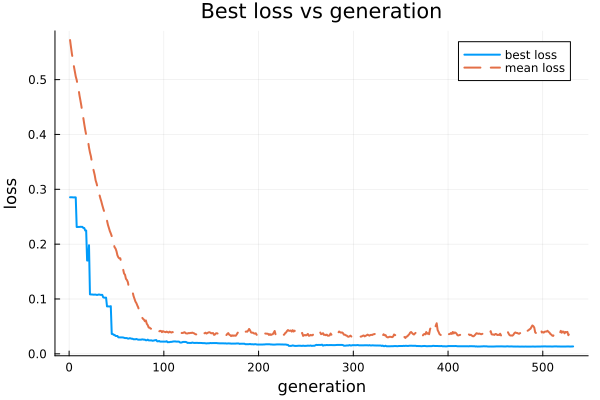

In [8]:
plot(state.history.best_loss, label="best loss", xlabel="generation", ylabel="loss", title="Best loss vs generation", lw=2, legend=:topright)
plot!(state.history.mean_loss, label="mean loss", lw=2, line=:dash)

In [9]:
best = argmin(state.fitness)
println("Best loss: ", state.fitness[best])

Best loss: 0.013470192252923426


Optimal index: 979
Adaptation error: 0.005175263107121242
sensitivity: 0.0033138935528894686 and  loss : 0.006686106447110532


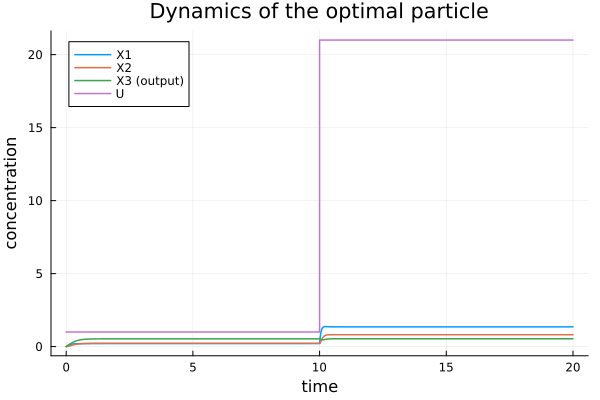

In [44]:
perturb = 20
opt_index =  829 
opt_index = argmin(state.fitness)

opt_pars_v = state.pool[opt_index]
opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)

sol = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, 1., [ perturb ], t0, t1)[1]
println("Optimal index: ", opt_index)
println("Adaptation error: ", abs(sol(t0)[3] - sol(t1)[3]))
println("sensitivity: ", abs(sol(t0)[3] - sol(t0+0.5)[3]), " and  loss : ", abs(abs(sol(t0)[3] - sol(t0+0.5)[3]) - 0.01))
plot(sol.t, vec2mat(sol.u)[:,1:4], label=["X1" "X2" "X3 (output)" "U"], lw=1.5, title="Dynamics of the optimal particle", xlabel="time", ylabel="concentration")

In [11]:
28
 111
 139
 181
 198
 215
 340
 574
 754
 821
 829

829

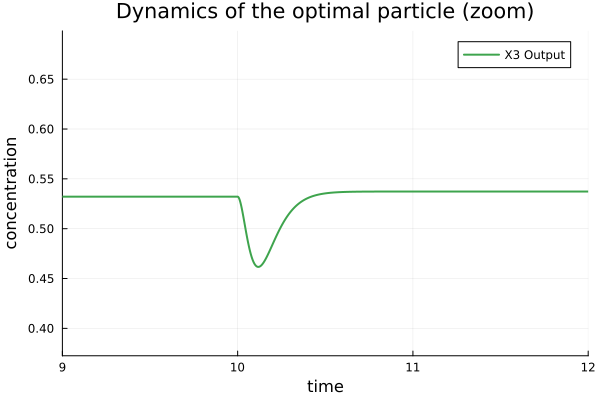

In [45]:
# zoom on reaction 3
plot(sol.t, vec2mat(sol.u)[:,3], label="X3 Output", xlabel="time", ylabel="concentration", title="Dynamics of the optimal particle (zoom)", lw=2, color=3)
xlims!(t0-1., t0+2)
ylims!(sol(t0-1)[3]-sol(t0-1)[3]*0.3, sol(t0+2)[3]+sol(t0+2)[3]*0.3)

In [13]:
gd_options_for_output = (
    alpha = gd_options.alpha,
    n_iter = gd_options.n_iter,
    use_pruning_heuristic = gd_options.use_pruning_heuristic,
    clip_value = gd_options.clip_value,
    use_gradient_normalization = gd_options.use_gradient_normalization,
    use_adagrad = gd_options.use_adagrad, # overrides use_adam!
    use_adam = gd_options.use_adam,
    use_random_perturbation = gd_options.use_random_perturbation,
    verbose = true,
    # placed here for convenience, should be in gd_loss_options
    symbolic_derivatives_of_loss = gd_options.symbolic_derivatives_of_loss
)
out = symbolic_gradient_descent(state.pool[best], crn_info, gd_options_for_output, gd_perturbation_options, gd_loss_options)

(parameters = [0.0, 0.7362275243618441, 0.014396171358974773, 0.5478803163201506, 0.0793309515453728, 1.21542383140315, 0.29526262628088873, 1.0845407138139367, 2.403271812587076, 0.017732264558666874  …  0.05146789784737093, 0.10911089438813165, 0.7063479374362164, 0.053954148023975274, 1.2602024143154595, 0.04290067754444997, 0.015479682676416067, 0.9133211478146126, 0.11303106407545875, 0.005881580494340323], loss_tape = Any[0.013470192301675366, 1.7503039943776353, 0.10145807140726162, 0.07010068454915709, 0.030423277240802456, 0.05835200736037103, 0.042528658735882345, 0.0336628860817699, 0.4250350864782896, 0.0384171020476457], loss_tape_array = Any[Num[0.0, 5.34114733603905e-10, 0.012154388057341637, 0.0013158037102189999], Num[0.0, 1.3725518103133999e-9, 0.012142411162371917, 1.7381615818427105], Num[0.0, 9.37963558852489e-10, 0.012147893857974192, 0.08931017661132389], Num[0.0, 4.4047175627028027e-10, 0.012154003381025968, 0.057946680727659364], Num[0.0, 8.841323913977735e-10,

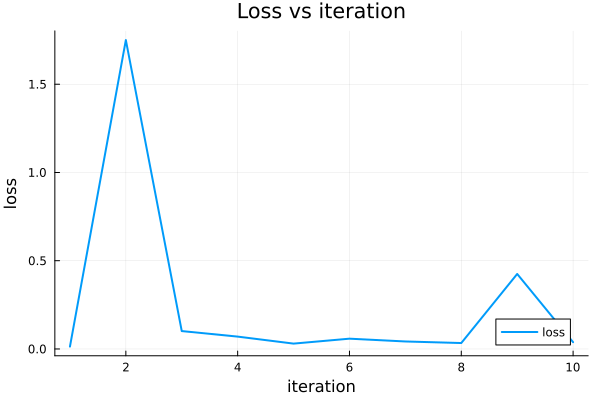

In [14]:
plot(1:length(out.loss_tape), out.loss_tape, label="loss", xlabel="iteration", ylabel="loss", title="Loss vs iteration", lw=2, legend=:bottomright)

In [46]:
using Symbolics
using LinearAlgebra
function joint_jacobian(i, j, jac, initial_conditions)
    A_ij = substitute(jac[i, j], unsym_dict(initial_conditions))
    return A_ij
end

opt_index = argmin(state.fitness)

opt_pars_v = state.pool[opt_index]
opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)

jac = Symbolics.substitute(calculate_jacobian(ode_crn), unsym_dict(opt_pars_l.p))

perturb = 2.5
steady_state_after_perturbation = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, 1., [ perturb ], t0, t1)[1](t1)[1:3]
steady_state_after_perturbation = [
    :x_1 => steady_state_after_perturbation[1],
    :x_2 => steady_state_after_perturbation[2],
    :x_3 => steady_state_after_perturbation[3]
]

A_21 = joint_jacobian(2, 1, jac, steady_state_after_perturbation)
A_32 = joint_jacobian(3, 2, jac, steady_state_after_perturbation)
A_22 = joint_jacobian(2, 2, jac, steady_state_after_perturbation)
A_31 = joint_jacobian(3, 1, jac, steady_state_after_perturbation)

println("A_21 = ", A_21)
println("A_32 = ", A_32)
println("A_22 = ", A_22)
println("A_31 = ", A_31)
println("A_22*A_31 = ", A_22*A_31)
println("A_21*A_32 = ", A_21*A_32)
println("A_22*A_31 - A_21*A_32 = ", A_22*A_31 - A_21*A_32)

A_21 = 6.821420437452952
A_32 = 4.525288603019236
A_22 = -11.512057300278924
A_31 = -2.6990620586175944
A_22*A_31 = 31.07175707581454
A_21*A_32 = 30.868896162008333
A_22*A_31 - A_21*A_32 = 0.2028609138062052


In [16]:
homeostatic_coefs_A21_A32 = []
homeostatic_coefs_A22_A31 = []
homeostatic_coefs = []

for par_set in state.pool
    opt_pars_v = par_set
    opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)

    jac = Symbolics.substitute(calculate_jacobian(ode_crn), unsym_dict(opt_pars_l.p))

    perturb = 2.5
    steady_state_after_perturbation = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, 1., [ perturb ], t0, t1)[1](t1)[1:3]
    steady_state_after_perturbation = [
        :x_1 => steady_state_after_perturbation[1],
        :x_2 => steady_state_after_perturbation[2],
        :x_3 => steady_state_after_perturbation[3]
    ]

    A_21 = joint_jacobian(2, 1, jac, steady_state_after_perturbation)
    A_32 = joint_jacobian(3, 2, jac, steady_state_after_perturbation)
    A_22 = joint_jacobian(2, 2, jac, steady_state_after_perturbation)
    A_31 = joint_jacobian(3, 1, jac, steady_state_after_perturbation)

    push!(homeostatic_coefs_A21_A32, A_21*A_32)
    push!(homeostatic_coefs_A22_A31, A_22*A_31)
    push!(homeostatic_coefs, A_22*A_31 - A_21*A_32)
end

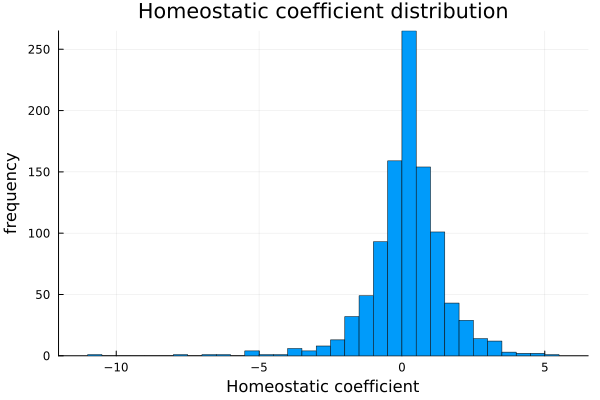

In [17]:
histogram([x.val for x in homeostatic_coefs], label=false, xlabel="Homeostatic coefficient", ylabel="frequency", title="Homeostatic coefficient distribution", lw=0.5, legend=:bottomright)

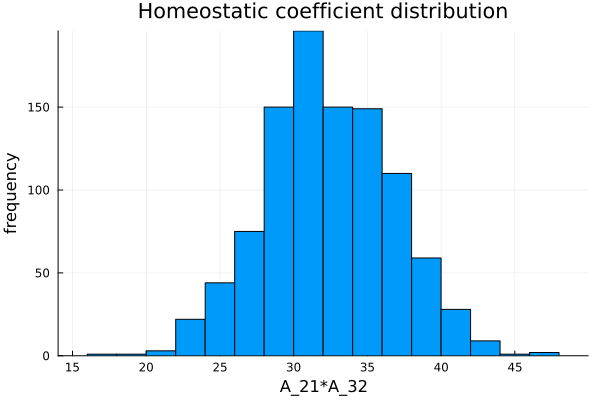

In [18]:
histogram([x.val for x in homeostatic_coefs_A21_A32], label=false, xlabel="A_21*A_32", ylabel="frequency", title="Homeostatic coefficient distribution", lw=1, legend=:bottomright)

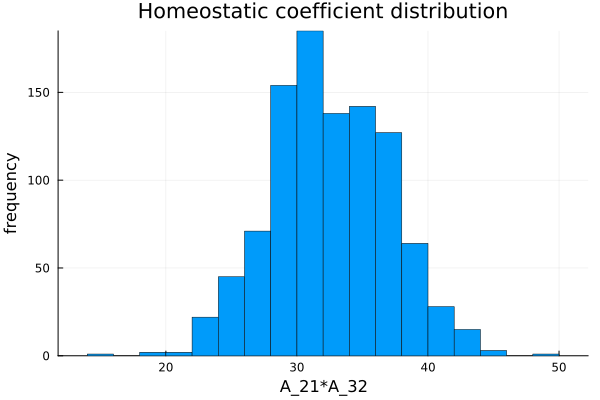

In [19]:
histogram([x.val for x in homeostatic_coefs_A22_A31], label=false, xlabel="A_21*A_32", ylabel="frequency", title="Homeostatic coefficient distribution", lw=0.5, legend=:bottomright)

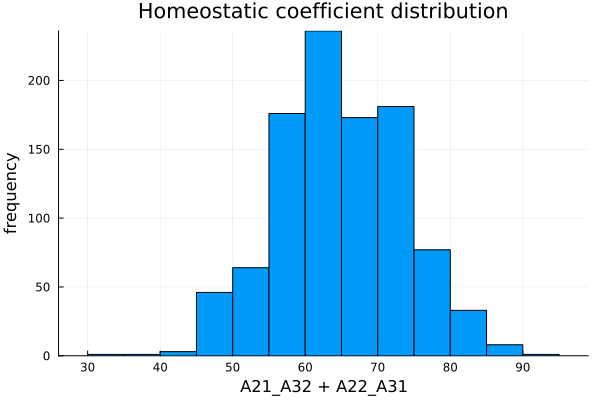

In [20]:
histogram([ x.val for x in homeostatic_coefs_A21_A32 + homeostatic_coefs_A22_A31], xlabel="A21_A32 + A22_A31", ylabel="frequency", title="Homeostatic coefficient distribution", lw=1, legend=false)

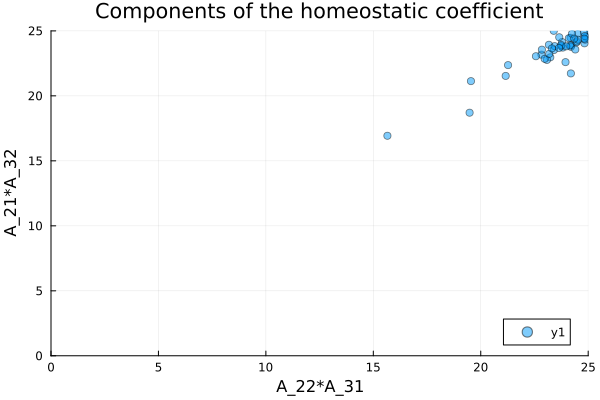

In [21]:
plot([x.val for x in homeostatic_coefs_A22_A31], [x.val for x in homeostatic_coefs_A21_A32], seriestype = :scatter, xlabel="A_22*A_31", ylabel="A_21*A_32", title="Components of the homeostatic coefficient", lw=2, legend=:bottomright, alpha=0.5)
xlims!(0,25)
ylims!(0,25)

Adapting toplogies

In [22]:
findall(x -> 0.01 < x < 0.1, [x.val for x in homeostatic_coefs])

39-element Vector{Int64}:
  34
  48
  64
  69
 116
 150
 167
 175
 182
 190
   ⋮
 824
 832
 834
 862
 890
 902
 928
 941
 977

IFF

NFB

In [24]:
findall(x -> 0.01 < x < 0.1, (abs.([x.val for x in homeostatic_coefs_A22_A31]) + abs.([x.val for x in homeostatic_coefs_A21_A32]))/2  )

Int64[]

In [25]:
sum(state.pool[494] .> 0.20)

46

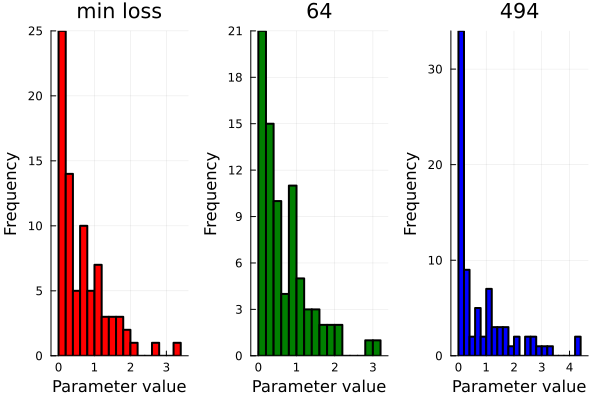

In [26]:
opt_index_options = [best, rand(1:length(state.pool)), 494]
opt_index_options_labels = ["min loss", "$(opt_index_options[2])", "494"]
opt_index_options_colors = [:red, :green, :blue]

hists = []
for i in 1:length(opt_index_options)
    opt_index = opt_index_options[i]
    opt_pars_v = state.pool[opt_index]
    opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, 3)
    h = histogram(opt_pars_v, label=opt_index_options_labels[i], xlabel="Parameter value", ylabel="Frequency", title=opt_index_options_labels[i], lw=2, legend=false, color=opt_index_options_colors[i], bins=20)
    push!(hists, h)
end
plot(hists..., layout=(1,3))

In [27]:
using JLD2

save_object("NFB-finding-run-1000.jld2", Dict(
    "state" => state,
    # all parameters 
    "ga_options" => Dict(
        genetic_pool_size => genetic_pool_size,
        death_rate => death_rate,
        mutation_rate => mutation_rate,
        gradient_mutation_rate => gradient_mutation_rate,
        duplication_rate => duplication_rate,
        crossover_rate => crossover_rate,
        max_generations => max_generations,
        p_cross => p_cross
    ),
    "crn_info" => crn_info,
    "gd_loss_options" => gd_loss_options,
    "gd_options" => gd_options,
    "gd_perturbation_options" => gd_perturbation_options
))    


In [28]:
test_load = load_object("NFB-finding-run-1000.jld2") 

Dict{String, Any} with 6 entries:
  "crn_info"                => (crn = ReactionSystem{NetworkProperties{Int64, B…
  "gd_perturbation_options" => (t0 = 10.0, t1 = 20.0, input = 1.0, perturbation…
  "state"                   => (pool = [[0.0, 1.03759, 0.0780593, 0.337221, 0.0…
  "ga_options"              => Dict{Any, Any}(#173=>#173, #167=>#167, #169=>#16…
  "gd_loss_options"         => (weights = [100.0, 10.0, 0.0125, 5.0], p = 0.001…
  "gd_options"              => (alpha = 0.1, n_iter = 10, use_pruning_heuristic…

In [35]:
sum(state.pool[1] .> 2.)

4